In [ ]:
import fastf1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt  
fastf1.Cache.enable_cache('/Users/zanderbonnet/Desktop/GCU/Proj/f1_cache')

In [48]:
year = 2025
e = 'Canada'

race = fastf1.get_session(year, e, 'R')
race.load()

qualifying = fastf1.get_session(year, e, 'Q')
qualifying.load()

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '1', '12', '81', '16', '44', '14', '27', '31', '55', '87', '22', '43', '5', '10', '6', '18', '4', '30', '23']
core           INFO 	Loading data for Canadian Grand Prix - Q

In [49]:
race.laps['LapTime'] = race.laps['LapTime'].dt.total_seconds()
qualifying.laps['LapTime'] = qualifying.laps['LapTime'].dt.total_seconds()

In [50]:
race.laps.columns


Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [51]:
pitlap = race.laps['PitOutTime'].notna()
pits = pitlap.rename('PitLap', inplace=True)

In [52]:
data = race.laps[['Driver','Team','LapTime','Compound','FreshTyre','TyreLife', 'LapNumber','TrackStatus']]
data = data.merge(pits, left_index=True, right_index=True)
fastest_laps = qualifying.laps.groupby('Driver')['LapTime'].min().reset_index()
data = data.merge(fastest_laps, on='Driver', suffixes=('', '_Qualifying'))
data = data.dropna()
data

,Driver,Team,LapTime,Compound,FreshTyre,TyreLife,LapNumber,TrackStatus,PitLap,LapTime_Qualifying
0,VER,Red Bull Racing,82.549,MEDIUM,False,4.0,1.0,1,False,71.059
1,VER,Red Bull Racing,76.418,MEDIUM,False,5.0,2.0,1,False,71.059
2,VER,Red Bull Racing,76.094,MEDIUM,False,6.0,3.0,1,False,71.059
3,VER,Red Bull Racing,75.925,MEDIUM,False,7.0,4.0,1,False,71.059
4,VER,Red Bull Racing,75.901,MEDIUM,False,8.0,5.0,1,False,71.059
...,...,...,...,...,...,...,...,...,...,...
1344,BEA,Haas F1 Team,75.476,HARD,True,47.0,65.0,12,False,72.306
1345,BEA,Haas F1 Team,118.863,HARD,True,48.0,66.0,24,False,72.306
1346,BEA,Haas F1 Team,116.832,SOFT,True,1.0,67.0,4,True,72.306
1347,BEA,Haas F1 Team,107.065,SOFT,False,2.0,68.0,4,True,72.306


In [53]:

catfeatures = ['Driver', 'Team', 'Compound', 'FreshTyre', 'PitLap', 'TrackStatus']
numerical_features = ['LapTime', 'TyreLife', 'LapNumber', 'LapTime_Qualifying']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), catfeatures)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=100
    ))
])


In [54]:
X = data.drop(columns=['LapTime'])
y = data['LapTime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['Driver', 'Team', 'Compound',
                                                   'FreshTyre', 'PitLap',
                                                   'TrackStatus'])])),
                ('regressor', GradientBoostingRegressor(random_state=100))])

In [55]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse:.2f} seconds')

Root Mean Squared Error: 3.54 seconds


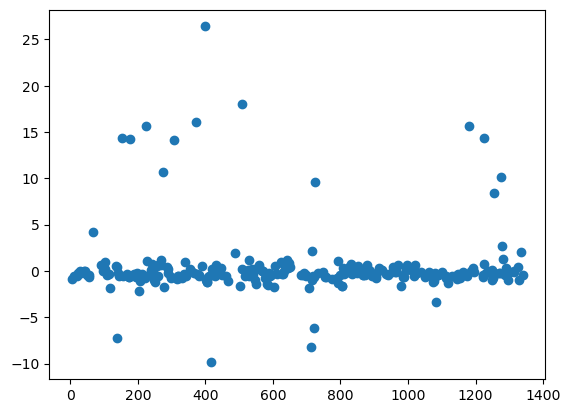

In [56]:
plt.scatter(y_test.index, y_test-y_pred)
plt.show()

In [57]:
X_train

,Driver,Team,Compound,FreshTyre,TyreLife,LapNumber,TrackStatus,PitLap,LapTime_Qualifying
1317,BEA,Haas F1 Team,HARD,True,20.0,38.0,1,False,72.306
124,GAS,Alpine,MEDIUM,True,2.0,55.0,1,False,72.667
1071,HAD,Racing Bulls,MEDIUM,True,1.0,1.0,1,False,71.867
1137,HAD,Racing Bulls,SOFT,False,4.0,67.0,4,True,71.867
201,ANT,Mercedes,HARD,True,25.0,63.0,1,False,71.391
...,...,...,...,...,...,...,...,...,...
805,COL,Alpine,MEDIUM,False,17.0,12.0,1,False,72.142
53,VER,Red Bull Racing,HARD,True,17.0,54.0,1,False,71.059
350,STR,Aston Martin,HARD,False,3.0,2.0,1,False,72.517
79,GAS,Alpine,HARD,True,10.0,10.0,1,False,72.667
